to check:
- Try chi-square test for among-variables & each variable-target to see they are highly related or not.
https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce
<br><br>
- Try converting the features into categorical features to see if the result changes.
=> when dtype="category", chi-square test couldn't be done due to:
TypeError: Neither the `x` nor `y` variable appears to be numeric.
<br><br>
- Try feature augmentation (sigmoid, tanh, etc.); search term "python feature augmentation"
<br><br>
- Try bagging:
<br>** Bagging, also known as bootstrap aggregation, is the ensemble learning method that is commonly used to reduce variance within a noisy dataset. In bagging, a random sample of data in a training set is selected with replacement—meaning that the individual data points can be chosen more than once.
<br>** Random Forest Classifier has several decision trees trained on the various subsets. This algorithm is a typical example of a bagging algorithm. Random Forests uses bagging underneath to sample the dataset with replacement randomly.
<br><br>
other notes:
- Exclude correlation part. Keep K-fold cross validation.
- Keep train-test ratio as 8:2.
- Try with simpler models first. Don't make it too complex as the data set is small and simple.

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import random
import time
import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning, RuntimeWarning))

# Libraries for plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Classifiers
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM, LinearSVC, NuSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier,\
                            GradientBoostingClassifier, BaggingClassifier

# Feature augmentation/transformation functions
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import SkewedChi2Sampler
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.kernel_approximation import AdditiveChi2Sampler
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import SplineTransformer

# Other functions for modeling and evaluation
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from scipy import stats
from scipy.stats.contingency import expected_freq
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

In [2]:
survey_df = pd.read_csv("C:/Users/Admin/Documents/GitHub/NlupKgfEgSOdYRuv/data/ACME-HappinessSurvey2020.csv")
print(survey_df.head(), "\n")
print(survey_df.info(), "\n")
survey_df.describe()

   Y  X1  X2  X3  X4  X5  X6
0  0   3   3   3   4   2   4
1  0   3   2   3   5   4   3
2  1   5   3   3   3   3   5
3  0   5   4   3   3   3   5
4  0   5   4   3   3   3   5 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB
None 



,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Convert  Y as categorical variable, instead of int, since Y is a class not a continuous variable.

In [3]:
survey_df["Y"] = survey_df["Y"].astype('category').cat.set_categories([0, 1], ordered=True)

Plot the distribution of each columns, including the target variable Y.

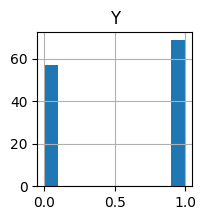

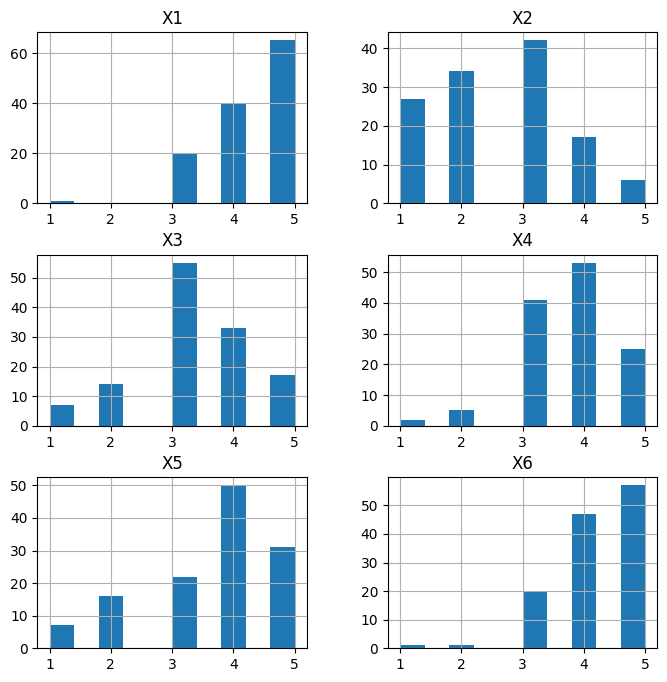

In [4]:
survey_df["Y"].hist(figsize=(2,2)).set_title("Y");
survey_df.iloc[:, [1,2,3,4,5,6,0]].hist(figsize=(8,8));

In [5]:
def run_chi_tests(dataframe, significance_level=0.05):
    chi_independence_df = pd.DataFrame(columns=[
        "Independent Variable",
        "Chi-square",
        "P-value",
        "Null Hypothesis",
        f"Reject Null Hypothesis at alpha={significance_level}?"
        ])

    fig, axes = plt.subplots(3, 2, figsize=(8,12))
    for i, col in enumerate(dataframe.drop("Y", axis=1).columns):
        sns.lineplot(dataframe, x=col, y="Y", ax=axes[i//2, i%2]).invert_yaxis()
        axes[i//2, i%2].set_yticks([0, 1])
        x = dataframe[col]
        y = dataframe["Y"]

        contingency_table = pd.crosstab(x, y)
        print(f'Contingecy table for {col} and Y:')
        print(contingency_table, "\n")

        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        print(f'Expected frequencies for {col} and Y:')
        print(expected)

        "1. Perform Chi-square test of goodness of fit and print out the result."
        chi_goodness_of_fit_test(x, col)

        "2. Perform Chi-Square test of Independence and store the result in a dataframe."
        chi_independence_df = chi_independence_test(chi_independence_df, col, chi2, p)
        print("--------------------------------------")

    return chi_independence_df


def chi_goodness_of_fit_test(data, col, significance_level=0.05):
    chi_goodness_of_fit_result = stats.chisquare(data)

    goodness_of_fit_null_hypothesis = f'There is no significant difference between {col} and the expected frequencies'
    if chi_goodness_of_fit_result.pvalue <= significance_level:
        goodness_of_fit_result = f""""
Null hypothesis: {goodness_of_fit_null_hypothesis}
Chi-square statistic: {chi_goodness_of_fit_result.statistic}
P-value: {chi_goodness_of_fit_result.pvalue}
Reject the null hypothesis
=> {col} is not representative of the population at alpha={significance_level}."""
    
    else: # Fail to reject the null hypothesis
        goodness_of_fit_result = f"""
Null hypothesis: {goodness_of_fit_null_hypothesis}
Chi-square statistic: {chi_goodness_of_fit_result.statistic}
P-value: {chi_goodness_of_fit_result.pvalue}
Failed to reject the null hypothesis
=> {col} is representative of the population at alpha={significance_level}"""
    print(goodness_of_fit_result)


def chi_independence_test(dataframe, col, chi2, p, significance_level=0.05):
    independence_null_hypothesis = f'{col} and Y are independent of each other'
    if p <= significance_level:
        independence_result = "Yes"
    else:
        independence_result = "No"

    dataframe = dataframe.append(
        {
        "Independent Variable": col,
        "Chi-square": chi2,
        "P-value": p,
        "Null Hypothesis": independence_null_hypothesis,
        f"Reject Null Hypothesis at alpha={significance_level}?": independence_result
        },
        ignore_index=True
    )
    return dataframe

Contingecy table for X1 and Y:
Y    0   1
X1        
1    1   0
3   12   8
4   24  16
5   20  45 

Expected frequencies for X1 and Y:
[[ 0.45238095  0.54761905]
 [ 9.04761905 10.95238095]
 [18.0952381  21.9047619 ]
 [29.4047619  35.5952381 ]]

Null hypothesis: There is no significant difference between X1 and the expected frequencies
Chi-square statistic: 18.46153846153846
P-value: 1.0
Failed to reject the null hypothesis
=> X1 is representative of the population at alpha=0.05
--------------------------------------
Contingecy table for X2 and Y:
Y    0   1
X2        
1   13  14
2   13  21
3   19  23
4   10   7
5    2   4 

Expected frequencies for X2 and Y:
[[12.21428571 14.78571429]
 [15.38095238 18.61904762]
 [19.         23.        ]
 [ 7.69047619  9.30952381]
 [ 2.71428571  3.28571429]]

Null hypothesis: There is no significant difference between X2 and the expected frequencies
Chi-square statistic: 61.36990595611287
P-value: 0.9999996901821208
Failed to reject the null hypothesis


,Chi-square,P-value,Null Hypothesis,Reject Null Hypothesis at alpha=0.05?
Independent Variable,,,,
X1,11.981200,0.007448,X1 and Y are independent of each other,Yes
X2,2.375107,0.667131,X2 and Y are independent of each other,No
X3,4.340259,0.361911,X3 and Y are independent of each other,No
X4,4.648222,0.325332,X4 and Y are independent of each other,No
X5,6.808039,0.146387,X5 and Y are independent of each other,No
X6,8.138426,0.086637,X6 and Y are independent of each other,No


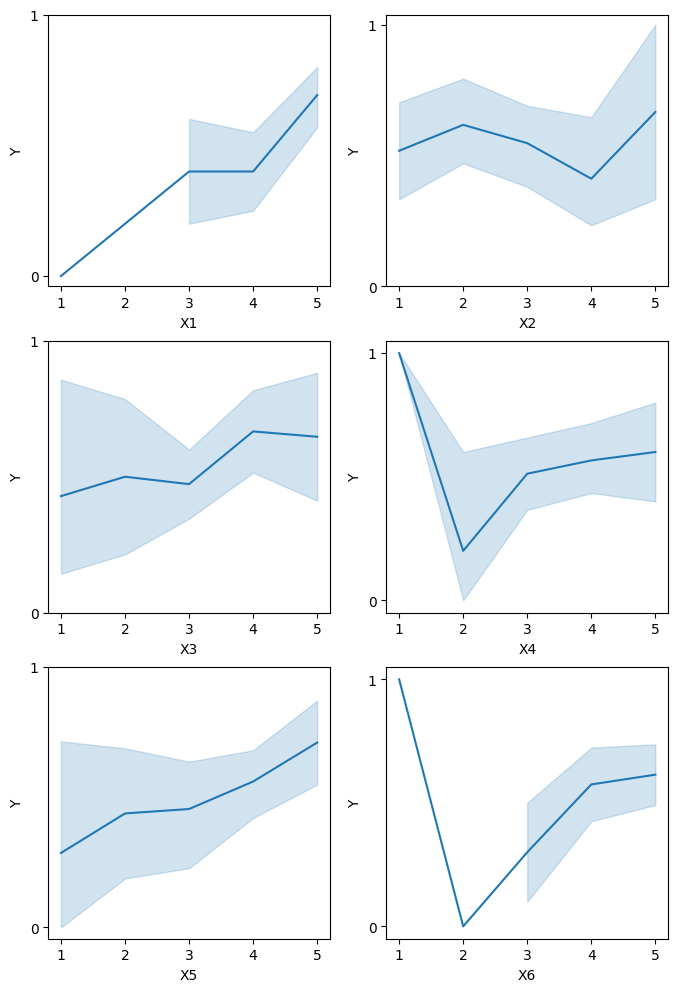

In [6]:
chi_independence_df = run_chi_tests(dataframe=survey_df)
print("Result of Chi-square test of independence:")
chi_independence_df.set_index("Independent Variable")

Based on the line charts, X1 and X5 seem to be good candidates as training features; higher X values = higher Y values in general and there are fluctuates for the other features, which indicates that they would not have strong predictive power on predicting Y based on the X values.

Based on the chi-square test of goodness of fit, all independent variables are representative of the population.

Hoewever, based on the chi-square test of independence, only X1 is associated with target Y and the rest are independent of Y at a significance level of 0.05, meaning with 95% of confidence X2-X6 are not associated with Y, thus would not be helpful in predicting Y.

If we increase the significance level to 0.1, then we can consider X6 is also associated with target Y with 90% of confidence, meaning it could be helpful in predicting Y too, in addition to X1.

Only using 1 out of 6 variables for supervised learning might not result in a robust model (since we are discarding 5/6 of the features), I would try to train a model with two features, that is X1 and X6 based on the chi-square tests.

#### check which variables are related to X1 - including them as training features could increase predicting power of X1.

In [7]:
significance_level = 0.05
chi_independence_df = pd.DataFrame(columns=[
    "Independent Variable",
    "Chi-square",
    "P-value",
    "Null Hypothesis",
    f"Reject Null Hypothesis at alpha={significance_level}?"
    ])

for i, col in enumerate(survey_df.drop("Y", axis=1).columns):
    x = survey_df[col]
    y = survey_df["X1"]

    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    chi_independence_df = chi_independence_test(chi_independence_df, col, chi2, p)

print("Result of Chi-square test of independence:")
chi_independence_df.set_index("Independent Variable")

Result of Chi-square test of independence:


,Chi-square,P-value,Null Hypothesis,Reject Null Hypothesis at alpha=0.05?
Independent Variable,,,,
X1,378.000000,6.735800e-76,X1 and Y are independent of each other,Yes
X2,9.014178,7.017190e-01,X2 and Y are independent of each other,No
X3,27.601271,6.324615e-03,X3 and Y are independent of each other,Yes
X4,12.799464,3.837835e-01,X4 and Y are independent of each other,No
X5,42.710726,2.527299e-05,X5 and Y are independent of each other,Yes
X6,58.313490,4.573138e-08,X6 and Y are independent of each other,Yes


In [32]:
def get_mean_accuracy_score(
        training_features,
        transformer=None,
        decomposer=None,
        classifier=LogisticRegressionCV(),
        dataframe=survey_df,
        target=survey_df["Y"],
        test_size=0.2,
        n=100):
    
    scores = []
    try:
        for i in range(n):
            X_balanced, y_balanced = SMOTE().fit_resample(dataframe[training_features], target)
            
            X_train, X_test, y_train, y_test = \
                train_test_split(X_balanced, y_balanced, test_size=0.2)
            
            if transformer==None:
                classifier.fit(X_train, y_train)
                score = accuracy_score(y_test, classifier.predict(X_test))
            
            elif decomposer!=None:
                X_transformed_train = transformer.fit_transform(X_train, y_train)
                X_transformed_test = transformer.transform(X_test)
                
                try:
                    components = decomposer.fit_transform(X_transformed_train)
                except ValueError:
                    print(f"Decomposition failed by {decomposer}!")
                
                classifier.fit(components, y_train)
                score = accuracy_score(y_test, classifier.predict(decomposer.transform(X_transformed_test)))
            
            else:
                X_transformed = transformer.fit_transform(X_train, y_train)  
                classifier.fit(X_transformed, y_train)
                score = accuracy_score(y_test, classifier.predict(transformer.transform(X_test)))

            scores.append(score)
    
    except Exception as e:
        print(e)
        print(f"transformer: {transformer}")
        print(f"decomposer: {decomposer}")
        print(f"classifier: {classifier}")

    if transformer==None and decomposer==None:
        print(f"Mean prediction accuracy score based on training with {training_features}: {np.mean(scores)}")
    else:
        return scores

In [9]:
get_mean_accuracy_score(["X1", "X6"])
get_mean_accuracy_score(["X1", "X3", "X6"])
get_mean_accuracy_score(["X1", "X5", "X6"])
get_mean_accuracy_score(["X1", "X3", "X5", "X6"])
get_mean_accuracy_score(["X1", "X3", "X4", "X5", "X6"])

Mean prediction accuracy score based on training with ['X1', 'X6']: 0.6089285714285714
Mean prediction accuracy score based on training with ['X1', 'X3', 'X6']: 0.5660714285714286
Mean prediction accuracy score based on training with ['X1', 'X5', 'X6']: 0.58
Mean prediction accuracy score based on training with ['X1', 'X3', 'X5', 'X6']: 0.5653571428571429
Mean prediction accuracy score based on training with ['X1', 'X3', 'X4', 'X5', 'X6']: 0.5646428571428571


X1 and X6 resulted in the best accuracy score, which confirms the findings from the chi-square tests.
Now, try feature augmentation using different techniques/transformers.

In [87]:
def get_dicts(transformers=None, transformer=None,
              classifiers=None, classifier=None,
              decomposers=None, decomposer=None,
              n=100):
    eval_dict = {}
    scores_dict = {}

    try:
        if transformers!=None:
            for transformer in transformers:
                start_time = time.time()
                scores = get_mean_accuracy_score(["X1", "X6"], transformer=transformer, n=n)
                time_elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
                
                eval_dict[transformer] = {
                    "Mean": np.mean(scores),
                    "Std": np.std(scores),
                    "Max": np.max(scores),
                    "Min": np.min(scores),
                    "Time elapsed": time_elapsed}
                scores_dict[transformer] = scores

                # print(f"transformer: {transformer}")
                # print(eval_dict[transformer], "\n")
                
        elif classifiers!=None:
            for classifier in classifiers:
                key = type(classifier).__name__
                start_time = time.time()
                if transformer==None:
                    scores = get_mean_accuracy_score(["X1", "X6"], classifier=classifier, n=n)
                else:
                    scores = get_mean_accuracy_score(["X1", "X6"],
                                                    classifier=classifier,
                                                    transformer=transformer,
                                                    n=n)
                time_elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
                
                eval_dict[key] = {
                    "Mean": np.mean(scores),
                    "Std": np.std(scores),
                    "Max": np.max(scores),
                    "Min": np.min(scores),
                    "Time elapsed": time_elapsed}
                scores_dict[key] = scores

                # print(f"classifier: {key}")
                # print(eval_dict[key], "\n")
        
        elif decomposers!=None:
            for decomposer in decomposers:
                start_time = time.time()
                scores = get_mean_accuracy_score(["X1", "X6"],
                                                transformer=AdditiveChi2Sampler(),
                                                decomposer=decomposer, n=n)
                time_elapsed = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
                
                eval_dict[decomposer] = {
                    "Mean": np.mean(scores),
                    "Std": np.std(scores),
                    "Max": np.max(scores),
                    "Min": np.min(scores),
                    "Time elapsed": time_elapsed}
                scores_dict[decomposer] = scores
                
                # print(f"decomposer: {decomposer}")
                # print(eval_dict[decomposer], "\n")

    except Exception as e:
        print(e)
        if transformer!=None:
            print(f"transformer: {transformer}")
        if decomposer!=None:
            print(f"decomposer: {decomposer}")
        if classifier!=None:
            print(f"classifier: {classifier}")

    return eval_dict, scores_dict


def plot_scores(scores_dict):
    fig, axes = plt.subplots(len(scores_dict.keys()), 1,
                    figsize=(len(scores_dict.keys())/2, len(scores_dict.keys())*3))
    fig.tight_layout(pad=5)
    for i, (transformer, scores) in enumerate(scores_dict.items()):
        ax = axes[i]
        ax.text(0.02, 0,
    f"""
    Mean: {round(np.mean(scores), 2)}
    Std: {round(np.std(scores), 2)}
    Max: {round(np.max(scores), 2)}
    Min: {round(np.min(scores), 2)}
    """)
        sns.distplot(scores, ax=ax)
        ax.set_title(transformer)
        ax.set_xlabel("Accuracy Score")
        ax.set_xbound(0, 1)

,Mean,Std,Max,Min,Time elapsed
AdditiveChi2Sampler(),0.648214,0.089125,0.821429,0.357143,00:00:15
PolynomialFeatures(degree=4),0.635714,0.076432,0.857143,0.464286,00:00:57
PolynomialFeatures(degree=3),0.625357,0.092512,0.821429,0.321429,00:00:49
RBFSampler(),0.624286,0.075842,0.821429,0.464286,00:00:20
PolynomialCountSketch(),0.623214,0.092771,0.821429,0.321429,00:00:18
PolynomialFeatures(),0.621786,0.089798,0.857143,0.428571,00:00:33
SplineTransformer(n_knots=2),0.611429,0.080382,0.785714,0.357143,00:00:17
SplineTransformer(n_knots=4),0.61,0.096055,0.821429,0.357143,00:00:17
Nystroem(),0.606071,0.089991,0.857143,0.321429,00:00:24
SplineTransformer(n_knots=3),0.605357,0.0796,0.785714,0.392857,00:00:17


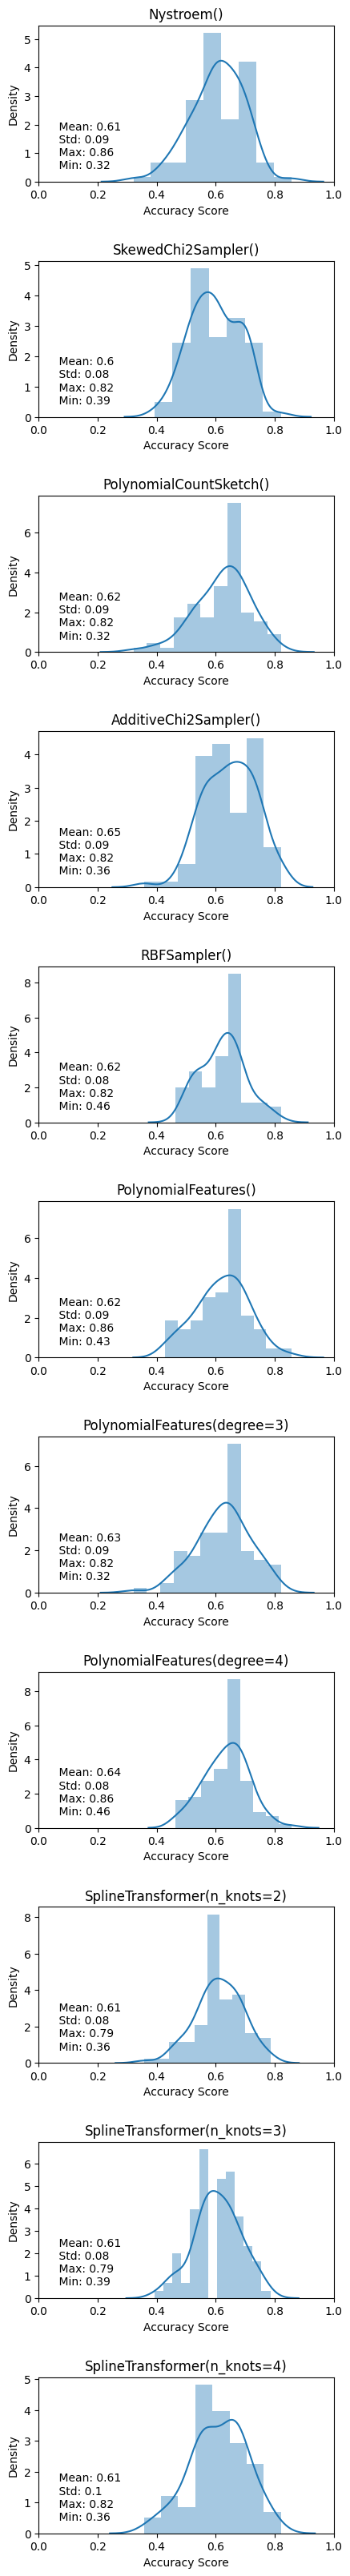

In [11]:
transformers = [
    Nystroem(),
    SkewedChi2Sampler(),
    PolynomialCountSketch(),
    AdditiveChi2Sampler(),
    RBFSampler(),
    PolynomialFeatures(2),
    PolynomialFeatures(3),
    PolynomialFeatures(4),
    SplineTransformer(2),
    SplineTransformer(3),
    SplineTransformer(4)
]
eval_dict, scores_dict = get_dicts(transformers=transformers)

plot_scores(scores_dict)

eval_df = pd.DataFrame(eval_dict).T
eval_df.sort_values(
    ["Mean", "Max", "Min", "Std", "Time elapsed"],
    ascending=[False, False, True, True, True])

concatenate those transformed features and try fitting a LogisticRegressionCV.

if the result is not great, try dementionality reduction
(PCA, FeatureAgglomeration, KernelPCA, FastICA, SparsePCA, IncrementalPCA, TruncatedSVD, MiniBatchSparsePCA)
 o reduce the number of features (i.e. to retain only the important componets as we've added hundreds of transformed features)

In [12]:
classifier = LogisticRegressionCV()
transformers = [
    Nystroem(),
    SkewedChi2Sampler(),
    PolynomialCountSketch(),
    AdditiveChi2Sampler(),
    RBFSampler(),
    PolynomialFeatures(2),
    PolynomialFeatures(3),
    PolynomialFeatures(4),
    SplineTransformer(2),
    SplineTransformer(3),
    SplineTransformer(4)
]

scores = []
for i in range(100):
    X_balanced, y_balanced = SMOTE().fit_resample(survey_df[["X1", "X6"]], survey_df["Y"])
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X_balanced, y_balanced, test_size=0.2)
    
    for i, transformer in enumerate(transformers):
        X_transformed_train = transformer.fit_transform(X_train, y_train)
        X_transformed_test = transformer.transform(X_test)
        if i==0:
            X_combined_train = X_transformed_train
            X_combined_test = X_transformed_test
        else:
            X_combined_train = np.concatenate((X_combined_train, X_transformed_train), axis=1)
            X_combined_test = np.concatenate((X_combined_test, X_transformed_test), axis=1)
        
    classifier.fit(X_combined_train, y_train)
    score = accuracy_score(y_test, classifier.predict(X_combined_test))
    scores.append(score)

np.mean(scores)

0.6242857142857143

accuracy is not great, likely due to too many less important features.<br>
just try the best performing transformer (i.e. AdditiveChi2Sampler)

In [13]:
classifier = LogisticRegressionCV()
transformer = AdditiveChi2Sampler() # => always performed better than the rest during testing.

scores = []
for i in range(100):
    X_balanced, y_balanced = SMOTE().fit_resample(survey_df[["X1", "X6"]], survey_df["Y"])
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X_balanced, y_balanced, test_size=0.2)

    
    X_transformed_train = transformer.fit_transform(X_train, y_train)
    X_transformed_test = transformer.transform(X_test)

    classifier.fit(X_transformed_train, y_train)
    score = accuracy_score(y_test, classifier.predict(X_transformed_test))
    scores.append(score)

np.mean(scores)

0.6478571428571429

try the same, with pca on it to reduce the number of features & improve accuracy by excluding less importance components.

,Mean,Std,Max,Min,Time elapsed
KernelPCA(),0.631071,0.09064,0.857143,0.392857,00:00:09
IncrementalPCA(),0.625,0.10394,0.821429,0.285714,00:00:09
MiniBatchSparsePCA(),0.6225,0.099521,0.821429,0.25,00:02:43
PCA(),0.62,0.078979,0.857143,0.428571,00:00:08
FastICA(),0.614286,0.094356,0.857143,0.392857,00:00:09
FeatureAgglomeration(),0.614286,0.099617,0.821429,0.392857,00:00:16
SparsePCA(),0.606429,0.090489,0.821429,0.392857,00:00:12
TruncatedSVD(),0.601429,0.101358,0.857143,0.357143,00:00:13


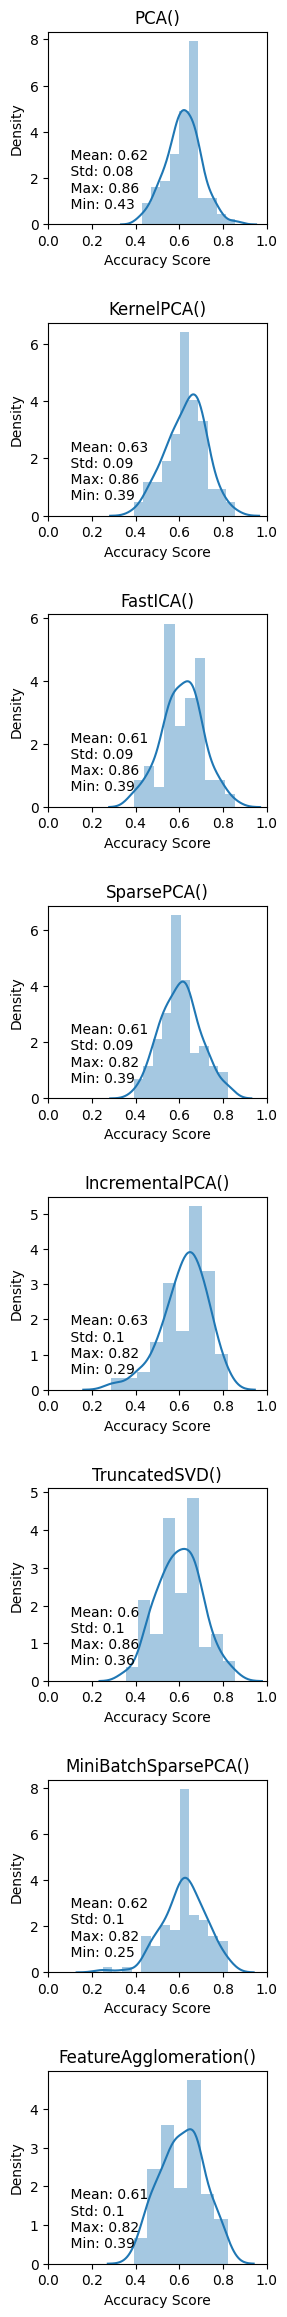

In [14]:
from sklearn.decomposition import PCA, KernelPCA, FastICA, SparsePCA, IncrementalPCA, TruncatedSVD, MiniBatchSparsePCA
from sklearn.cluster import FeatureAgglomeration

classifier = LogisticRegressionCV()
transformer = AdditiveChi2Sampler()
decomposers = [
    # PCA(n_components=0.95, svd_solver='full'),
    PCA(),
    KernelPCA(),
    FastICA(),
    SparsePCA(),
    IncrementalPCA(),
    TruncatedSVD(),
    MiniBatchSparsePCA(),
    FeatureAgglomeration()
]
eval_dict, scores_dict = get_dicts(decomposers=decomposers)

plot_scores(scores_dict)

eval_df = pd.DataFrame(eval_dict).T
eval_df.sort_values(
    ["Mean", "Max", "Min", "Std", "Time elapsed"],
    ascending=[False, False, True, True, True])

decomposers actually reduced the accuracy.
only proceed with transformer = AdditiveChi2Sampler()
Try different models to find the best one.

The dual coefficients or intercepts are not finite. The input data may contain large values and need to bepreprocessed.
transformer: AdditiveChi2Sampler()
decomposer: None
classifier: NuSVC()
zero-size array to reduction operation maximum which has no identity
transformer: AdditiveChi2Sampler()
classifier: NuSVC()


,Mean,Std,Max,Min,Time elapsed
LogisticRegression,0.658333,0.086398,0.857143,0.392857,00:00:08
AdaBoostClassifier,0.654643,0.083867,0.857143,0.392857,00:00:49
DecisionTreeClassifier,0.653571,0.079299,0.857143,0.428571,00:00:03
LogisticRegressionCV,0.652976,0.087553,0.928571,0.392857,00:00:55
BernoulliNB,0.65,0.080284,0.857143,0.357143,00:00:03
LinearDiscriminantAnalysis,0.647024,0.078758,0.857143,0.464286,00:00:04
GradientBoostingClassifier,0.645833,0.083831,0.892857,0.392857,00:00:54
LinearSVC,0.642381,0.087091,0.821429,0.392857,00:00:03
RandomForestClassifier,0.641905,0.079212,0.892857,0.357143,00:01:19
ExtraTreesClassifier,0.640357,0.088245,0.857143,0.357143,00:01:12


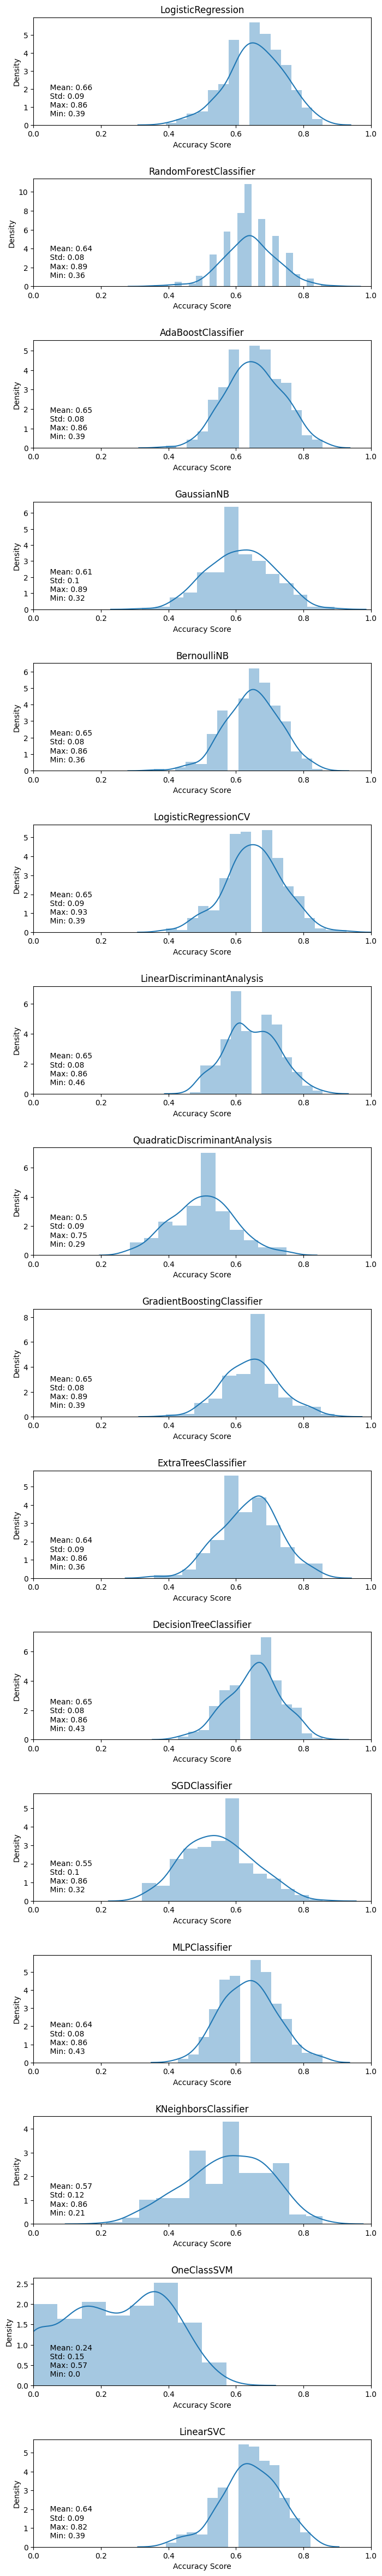

In [88]:
logistic_regression = LogisticRegression()
random_forest = RandomForestClassifier()
ada_boost = AdaBoostClassifier()
gaussian = GaussianNB()
bernoulli = BernoulliNB()
logistic_regression_cv = LogisticRegressionCV()
linear_discriminant = LinearDiscriminantAnalysis()
quadratic_discriminant = QuadraticDiscriminantAnalysis()
gradient_boosting = GradientBoostingClassifier()
extra_trees = ExtraTreesClassifier()
decision_tree = DecisionTreeClassifier()
sgd = SGDClassifier()
mlp = MLPClassifier()
k_neighbors = KNeighborsClassifier()
one_class_svm = OneClassSVM()
linear_scv = LinearSVC()
nu_svc = NuSVC()
svc = SVC()
bagging = BaggingClassifier()

classifiers = [logistic_regression, random_forest, ada_boost, gaussian, bernoulli,
              logistic_regression_cv, linear_discriminant, quadratic_discriminant, gradient_boosting,
              extra_trees, decision_tree, sgd, mlp, k_neighbors,
              one_class_svm, linear_scv, nu_svc, svc, bagging]

eval_dict, scores_dict = get_dicts(classifiers=classifiers, transformer=AdditiveChi2Sampler(), n=300)

plot_scores(scores_dict)

eval_df = pd.DataFrame(eval_dict).T
eval_df.sort_values(
    ["Mean", "Max", "Min", "Std", "Time elapsed"],
    ascending=[False, False, True, True, True])

# hyperparameter tuning, using randomized_search(StratifiedShuffleSplit, RandomizedSearchCV)

In [ ]:
def randomized_search(model, X_train, y_train, params,
                      scoring="accuracy", test_size=0.2, n_splits=10, n_iter=10):
    sss = StratifiedShuffleSplit(test_size=test_size, n_splits=n_splits) # n_splits=10 by default
    best_searched = RandomizedSearchCV(estimator=model, param_distributions=params, cv=sss,
                                        scoring=scoring, n_iter=n_iter) # n_iter=10 by default
    best_searched.fit(X_train, y_train)
    return best_searched

In [ ]:
transformer = AdditiveChi2Sampler() # => always performed better than the rest during testing.

X_balanced, y_balanced = SMOTE().fit_resample(survey_df[["X1", "X6"]], survey_df["Y"])

X_train, X_test, y_train, y_test = \
    train_test_split(X_balanced, y_balanced, test_size=0.2)

X_transformed_train = transformer.fit_transform(X_train, y_train)
X_transformed_test = transformer.transform(X_test)

### try hyperparameter tuning for the best model
best_classifier = LogisticRegression()
params = {
    "n_estimators": np.arange(10,200,10),
    # "criterion": ["gini", "entropy", "log_loss"],
    # "min_weight_fraction_leaf": np.arange(0, 1, 0.01),
    "max_features": ["sqrt", "log2", None],
    "warm_start": [True, False],
    "class_weight": ["balanced", "balanced_subsample", None],
    "ccp_alpha": np.arange(0, 1, 0.01)
}
best_searched = randomized_search(best_classifier, X_transformed_train, y_train, params)
best_searched.best_estimator_, best_searched.best_score_, best_searched.best_params_

finally, get accuracy score with the best models with best params, on X_transformed_test & y_test

if it failed to achieve the target accuracy score, try hyperparameter tuning for the second best model, and so on.

# below sections to be removed.

also try PCA to the original dataset to see if the model performs well without feature augmentation.

In [15]:
# Visualize all the principal components
import plotly.express as px
from sklearn.decomposition import PCA

oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(survey_df.drop("Y", axis=1), survey_df["Y"].astype('category'))

pca = PCA()
components = pca.fit_transform(X_balanced)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
labels["color"] = "Target Y"

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(5),
    color=y_balanced,
    height=800
)
fig.update_traces(diagonal_visible=False)
fig.show()
print(f"Variance explained by PC 1-5: {pca.explained_variance_ratio_[:5].sum()}")

Variance explained by PC 1-5: 0.9411674648588575


pca on the original features might not be very helpful based on the plots - Y values of 0 and 1 are not clearly seperated.
=> the below test confirms it.

In [16]:
scores = []
for i in range(100):
    oversample = SMOTE()
    X_balanced, y_balanced = oversample.fit_resample(survey_df.drop("Y", axis=1), survey_df["Y"].astype('category'))
    X_train, X_test, y_train, y_test = \
        train_test_split(X_balanced, y_balanced, test_size=0.2)

    clf = LogisticRegressionCV()
    pca = PCA()
    components = pca.fit_transform(X_train)
    clf.fit(components, y_train)
    score = accuracy_score(y_test, clf.predict(pca.transform(X_test)))
    scores.append(score)
np.mean(scores)

0.5549999999999999

In [17]:
# Plotting explained variance
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes

oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(survey_df.drop("Y", axis=1), survey_df["Y"].astype('category'))

pca = PCA()
pca.fit(X_balanced)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)
# https://plotly.com/python/pca-visualization/

In [18]:
# 2D PCA Scatter Plot
import plotly.express as px
from sklearn.decomposition import PCA

oversample = SMOTE()
X_balanced, y_balanced = oversample.fit_resample(survey_df.drop("Y", axis=1), survey_df["Y"].astype('category'))

pca = PCA(n_components=2)
components = pca.fit_transform(X_balanced)

fig = px.scatter(components, x=0, y=1, color=y_balanced, labels={"color": "Target Y"})
fig.show()

for all best models,
hyperparameter tuning with augmented features (used the randomized_search function, with default setting as much as possible?)

try voting classifier after hyperparameter tuning - from sklearn.ensemble import VotingClassifier

set random state and train-test-split, and the train and test the hyperparameter-tuned model, with the augmented features.

if all these not work, can try neural network from keras.